In [1]:
from pandas.api.types import CategoricalDtype
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import DataFrame, Series 
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
import json

In [2]:
list_of_issues_dict_data = [json.loads(line) for line in open('SPM587SP19_issues.json')]

In [3]:
# Create the DataFrame object for the list_of_issues_dict_data object

issues_df = DataFrame(list_of_issues_dict_data)

In [4]:
# Prepare and Clean the dataframe object

wrangled_issues_df = issues_df[['Author','State','closed_at','created_at','issue_number','labels']]
wrangled_issues_df.loc[0:len(wrangled_issues_df), 'OriginationPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'DetectionPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Category']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Priority']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Status']= np.NaN

In [5]:
for i in range(0, len(wrangled_issues_df)):
    if wrangled_issues_df.iloc[i]['labels']:
        for label in wrangled_issues_df.iloc[i]['labels']:
            label_name= (label.split(':'))[0]
            label_value= (label.split(':'))[1]
            wrangled_issues_df.loc[i, label_name]=label_value

In [6]:
#Create a Data frame from issues to get CLosed and Create Days and dates

data_frame2 = issues_df[['Author','issue_number','closed_at','created_at']]
data_frame2.loc[0:2, 'Closed_on']= np.NaN
data_frame2.loc[0:4,'Created_on']= np.NaN

for i in range(0, len(wrangled_issues_df)):
    if wrangled_issues_df.iloc[i]['closed_at']:
        closed_date_obj = datetime.strptime(wrangled_issues_df.iloc[i]['closed_at'], "%Y-%m-%d")
        weekday =  closed_date_obj.strftime("%A")
        data_frame2.loc[i,'Closed_on'] = weekday
        data_frame2.loc[i,'closed_at'] = pd.to_datetime(wrangled_issues_df.iloc[i]['closed_at'])
    if wrangled_issues_df.iloc[i]['created_at']:
        created_date_obj = datetime.strptime(wrangled_issues_df.iloc[i]['created_at'], "%Y-%m-%d")
        weekday = created_date_obj.strftime("%A")
        data_frame2.loc[i,'Created_on'] = weekday
        data_frame2.loc[i,'created_at'] = pd.to_datetime(wrangled_issues_df.iloc[i]['created_at'])

c:\users\chaet\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\chaet\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
data_frame2.head()

,Author,issue_number,closed_at,created_at,Closed_on,Created_on
0,DSP19SCM782,491,None,2019-04-21 00:00:00,NaN,Sunday
1,DSP19SCM782,490,None,2019-04-21 00:00:00,NaN,Sunday
2,DSP19SCM781,489,None,2019-04-21 00:00:00,NaN,Sunday
3,DSP19SCM781,488,None,2019-04-21 00:00:00,NaN,Sunday
4,DSP19SCM781,487,None,2019-04-21 00:00:00,NaN,Sunday


c:\users\chaet\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


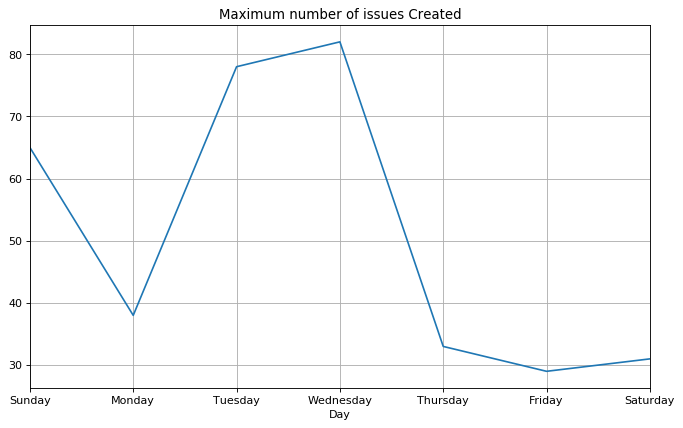

In [8]:
Create_day_L = DataFrame(data_frame2['Created_on'].value_counts().rename_axis('Day')).reset_index()
Create_day_L.columns = ['Day','counts']

days = ['Sunday' , 'Monday','Tuesday' , 'Wednesday' , 'Thursday' , 'Friday', 'Saturday']
Create_day_L['Day'] = Create_day_L['Day'].astype('category', categories=days, ordered=True)
df_weekday = Create_day_L.groupby(['Day']).sum().reindex(days)

model = ARIMA(Create_day_L['counts'], order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast()

time_series = df_weekday['counts']
decomp = seasonal_decompose(time_series,freq=1)

plt.figure(figsize=(10, 6), dpi=80)
decomp.trend.plot(grid=True,title='Maximum number of issues Created')


c:\users\chaet\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


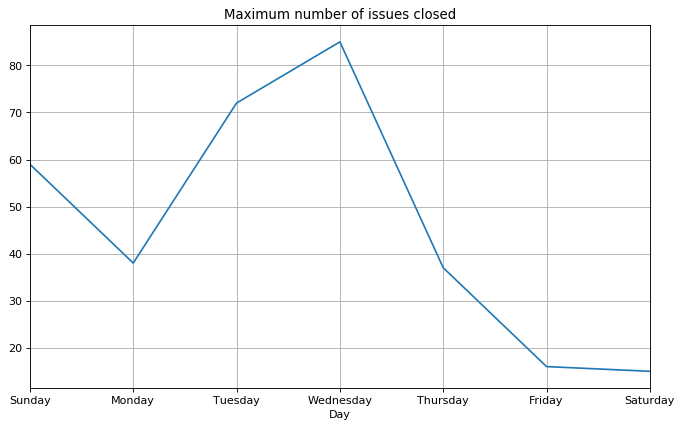

In [9]:
Closed_day_L= DataFrame(data_frame2['Closed_on'].value_counts().rename_axis('Day')).reset_index()
Closed_day_L.columns = ['Day','counts']

Closed_day_L['Day'] = Closed_day_L['Day'].astype('category', categories=days, ordered=True)
df_weekday = Closed_day_L.groupby(['Day']).sum().reindex(days)

model = ARIMA(Closed_day_L['counts'], order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast()

time_series = df_weekday['counts']
decomp = seasonal_decompose(time_series,freq=1)

plt.figure(figsize=(10, 6), dpi=80)
decomp.trend.plot(grid=True,title='Maximum number of issues closed')

In [10]:
Create_date_L = DataFrame(data_frame2['created_at'].value_counts().sort_index()).reset_index()
Create_date_L.columns = ['Date','counts']
Create_date_L.head()

,Date,counts
0,2019-03-24,1
1,2019-03-29,2
2,2019-03-30,9
3,2019-03-31,42
4,2019-04-01,12


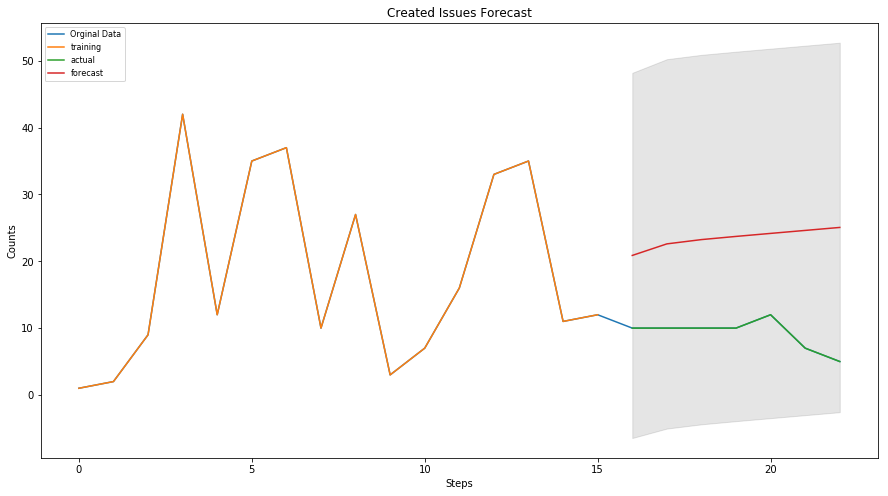

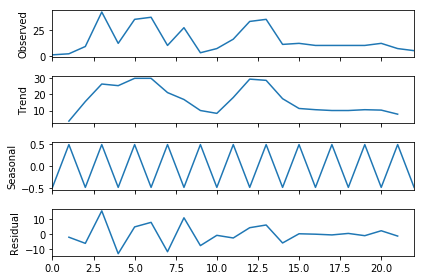

In [11]:
#Change the data to series format for model over train and fitting

series = pd.Series(Create_date_L['counts'])

#Set last 5 rows as test dataset
split_data = len(series) - 7 
train, test = series[0:split_data], series[split_data:]

model = ARIMA(train, order=(1,1,1))
fitted = model.fit(disp=1)  
fc, se, conf = fitted.forecast(7, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15,8))
plt.ylabel('Counts')
plt.xlabel('Steps')
plt.title('Created Issues Forecast')
plt.plot(series, label='Orginal Data')
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=0.1)
plt.legend(loc='upper left', fontsize=8)

decomp = seasonal_decompose(series,freq=2)
decomp.plot()
plt.show()

In [12]:
Closed_date_L = DataFrame(data_frame2['closed_at'].value_counts().sort_index()).reset_index()
Closed_date_L.columns = ['Date','counts']
Closed_date_L.head()

,Date,counts
0,2019-03-31,25
1,2019-04-01,12
2,2019-04-02,34
3,2019-04-03,34
4,2019-04-04,14


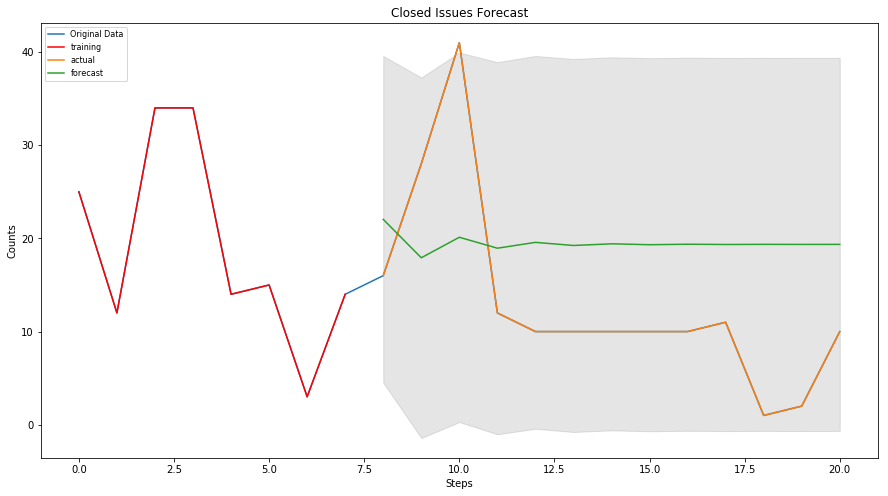

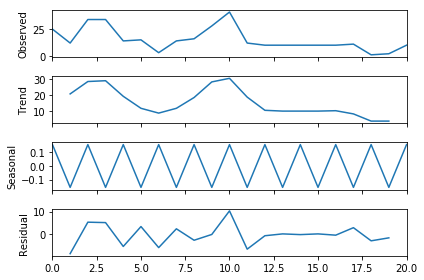

In [13]:
series2 = pd.Series(Closed_date_L['counts'])

#Set last 5 rows as test dataset
split_data = len(series2) - 13 
train, test = series2[0:split_data], series2[split_data:]

model = ARIMA(train, order=(1,0,1))
fitted = model.fit(disp=0)  
fc, se, conf = fitted.forecast(13, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15,8))
plt.ylabel('Counts')
plt.xlabel('Steps')
plt.title('Closed Issues Forecast')
plt.plot(series2, label='Original Data')
plt.plot(train, label='training',color='red')
plt.plot(test, label='actual')
# plt.plot(series2, label='Original Data')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=0.1)
plt.legend(loc='upper left', fontsize=8)

decomp = seasonal_decompose(series2,freq=2)
decomp.plot()
plt.show()

## Pull Request Data

In [14]:
pull_request_dict_data = [json.loads(line) for line in open('SPM587SP19_pulls.json')]

In [15]:
pull_requests_df = DataFrame(pull_request_dict_data)

In [16]:
PullRequestsbyCRD = DataFrame(pull_requests_df['created_at'].value_counts().sort_index()).reset_index()
PullRequestsbyCRD.columns = ['ds','y']


In [17]:
PullRequestsbyCRD.head()

,ds,y
0,2019-03-28,1
1,2019-04-01,1
2,2019-04-02,25
3,2019-04-03,25
4,2019-04-04,15


c:\users\chaet\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:765: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs


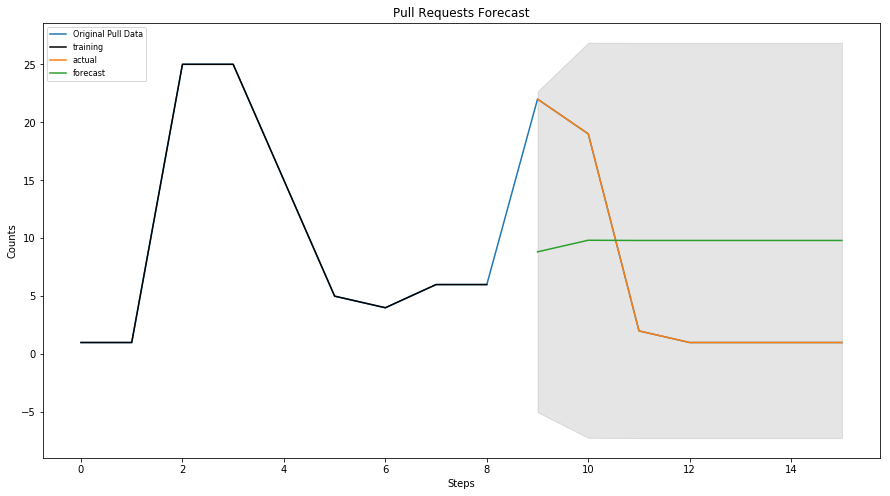

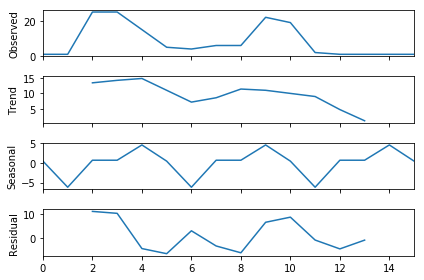

In [18]:
#Convert the RequestsbyCreateDate frame to series 
pull_series = pd.Series(PullRequestsbyCRD['y'])

#Set last 5 rows as test dataset
split_data = len(pull_series) - 7
train, test = pull_series[0:split_data], pull_series[split_data:]

model = ARIMA(train, order=(1,0,1))
fitted = model.fit()  
fc, se, conf = fitted.forecast(7, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15,8))
plt.ylabel('Counts')
plt.xlabel('Steps')
plt.title('Pull Requests Forecast')
plt.plot(pull_series, label='Original Pull Data')
plt.plot(train, label='training',color='Black')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=0.1)
plt.legend(loc='upper left', fontsize=8)

decomp = seasonal_decompose(pull_series,freq=5)
decomp.plot()
plt.show()


## Commit Data 

In [19]:
commits_dict_data = [json.loads(line) for line in open('SPM587SP19_commits.json')]

In [20]:
commits_df = DataFrame(commits_dict_data)

In [21]:
CommitsbyCreateDate = pd.DataFrame(columns=['ds', 'y'])

for i in range(len(commits_df)):
    data =  commits_df.iloc[i]['created_at']
    CommitsbyCreateDate.loc[i,'ds'] = datetime.strptime(data, '%Y-%m-%dT%H:%M:%SZ').date()

CommitsbyCreateDate = (CommitsbyCreateDate['ds'].value_counts().sort_index()).reset_index()
CommitsbyCreateDate.columns = ['ds','y']

In [22]:
CommitsbyCreateDate

,ds,y
0,2019-03-24,3
1,2019-03-27,1
2,2019-03-28,15
3,2019-03-29,27
4,2019-04-01,2
5,2019-04-02,88
6,2019-04-03,65
7,2019-04-04,50
8,2019-04-05,14
9,2019-04-06,7


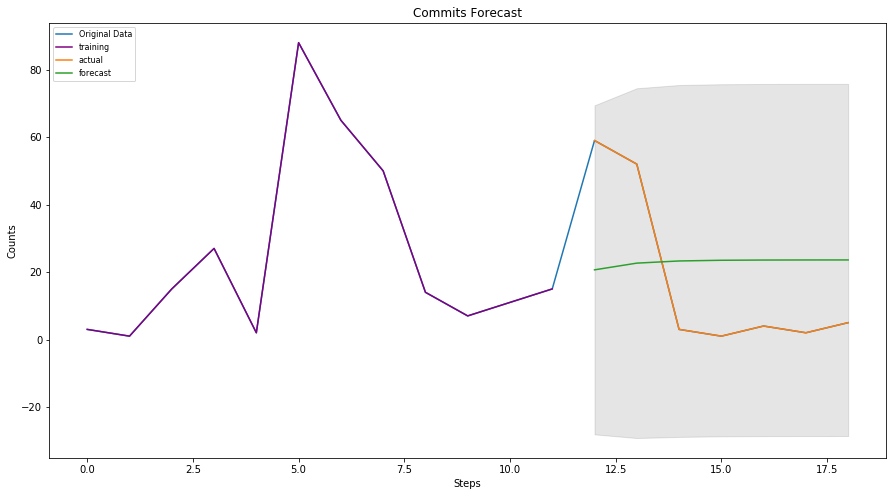

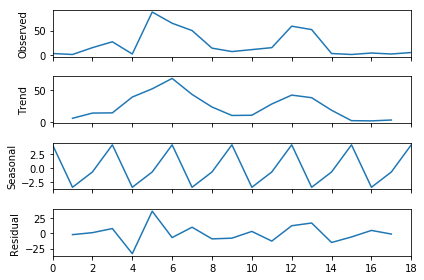

In [23]:
#Convert the CommitsbyCreateDate frame to series 
commit_series = pd.Series(CommitsbyCreateDate['y'])

#Set last 5 rows as test dataset
split_data = len(commit_series) - 7
train, test = commit_series[0:split_data], commit_series[split_data:]

model = ARIMA(train, order=(1,0,1))
fitted = model.fit()  
fc, se, conf = fitted.forecast(7, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15,8))
plt.ylabel('Counts')
plt.xlabel('Steps')
plt.title('Commits Forecast')
plt.plot(commit_series, label='Original Data')
plt.plot(train, label='training',color='purple')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=0.1)
plt.legend(loc='upper left', fontsize=8)

decomp = seasonal_decompose(commit_series,freq=3)
decomp.plot()
plt.show()
